# Lab | Cleaning numerical data

#### 1. Import the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler 
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.neighbors import KNeighborsRegressor

import seaborn as sns

def round_up(x):
    if x%1>=0.5:
        return int(x+1)
    return int(x)

#### 2. Load the file. First look at its main features (head, shape, info), Rename the columns so they follow the PE8 (snake case) (lower_case_with_underscores), change effective to date column to datetime format.

In [2]:
# reading csv
customer_df = pd.read_csv("./files_for_lab/we_fn_use_c_marketing_customer_value_analysis.csv")
# I convert to snake_case
customer_df.columns = map(lambda x:re.sub(r"([a-z]{1})([A-Z]{1})", r"\1 \2",x),customer_df.columns)
customer_df.columns = list(map(lambda x: x.lower(), customer_df.columns))
customer_df.columns = customer_df.columns.str.replace(' ','_')

In [3]:
# displaying information
display(customer_df.head())
display(customer_df.shape)
#display(customer_df.info())

,customer,state,customer_lifetime_value,response,coverage,education,effective_to_date,employment_status,gender,income,...,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


(9134, 24)

In [4]:
# (I will create an additional column for a later lab)
customer_df['week_day'] = pd.to_datetime(customer_df['effective_to_date'], format = "%m/%d/%y").dt.day_name()
customer_df['month'] = pd.to_datetime(customer_df['effective_to_date'], format = "%m/%d/%y").dt.month_name()

# changing column to datetime
customer_df['effective_to_date']=pd.to_datetime(customer_df['effective_to_date'], format = "%m/%d/%y").dt.date

#### 4. Define a function that differentiates between continuous and discrete variables. Hint: The number of unique values might be useful. Store continuous data into a continuous_df variable and do the same for discrete_df

In [5]:
def is_continuous(column):
    # I basically assume a column is continous if it's both a number and n_unique_values/total_rows > 1%. Otherwise,
    # I will return 0 (non-continous -> discrete). The ratio above is equal to the inverse of the mean of the count of the categories:
    # n_unique_values/total_rows = n_unique_values/(count_cat1+count_cat2+...+count_catN) = count_cat_mean^(-1). So by setting
    # a threshold of ratio = 0.01 we're saying count_cat_mean = 0.01^(-1) = 100, which means that a column has in average 100
    # values for each unique label.
    if column.dtypes in ['int64','float64'] and len(column.unique())/len(column) > 0.01:
        #print(column.name+' is continuous with ratio %.3f.' %(len(column.unique())/len(column)))
        return 1
    elif len(column.unique())/len(column) <= 0.01:
        return 0
    else:
        return None

In [6]:
# I define blank dataframes to store the data
continuous_df = pd.DataFrame()
discrete_df = pd.DataFrame()

# Iterating for each column, checking its type and assigning accordingly. 
for column in customer_df.select_dtypes(np.number).columns:
    if is_continuous(customer_df[column]) == 1:
        continuous_df = pd.concat([continuous_df, customer_df[column]], axis=1)
    else:
        discrete_df = pd.concat([discrete_df, customer_df[column]], axis=1)


### 5. Plot a correlation matrix, comment what you see. 

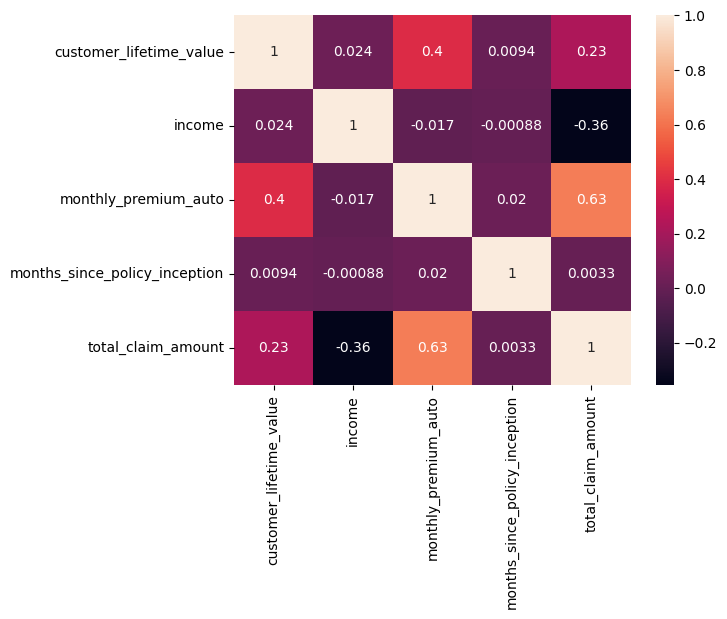

In [7]:
sns.heatmap(continuous_df.corr(), annot=True)
plt.show()
# I see some moderate correlations between monthly premium and customer_lifetime_value 
# and between monthly_premium_auto and total_claim_amount

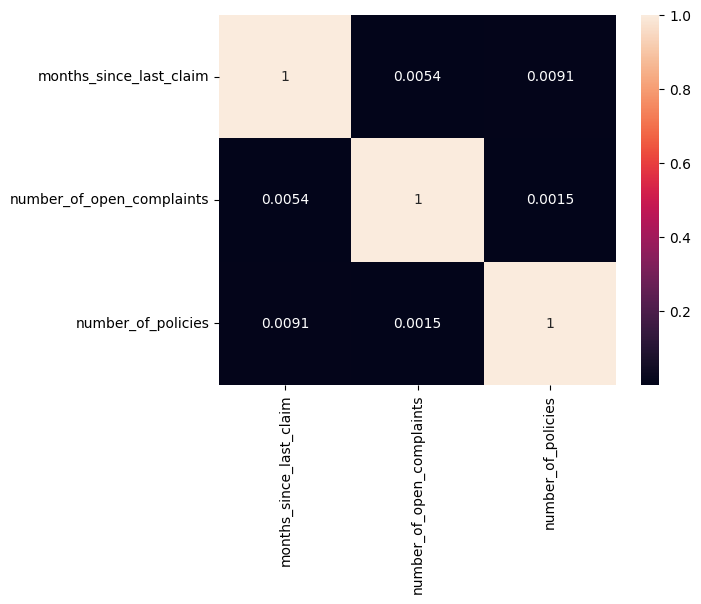

In [8]:
sns.heatmap(discrete_df.select_dtypes(np.number).corr(), annot=True)
plt.show()
# I see no relevant correlations. 

#### Create a function to plot every discrete variable. Do the same with the continuous variables (Be Careful, you may need to change the plot type to one better suited for continuous data!) Comment what you can see in the plots.

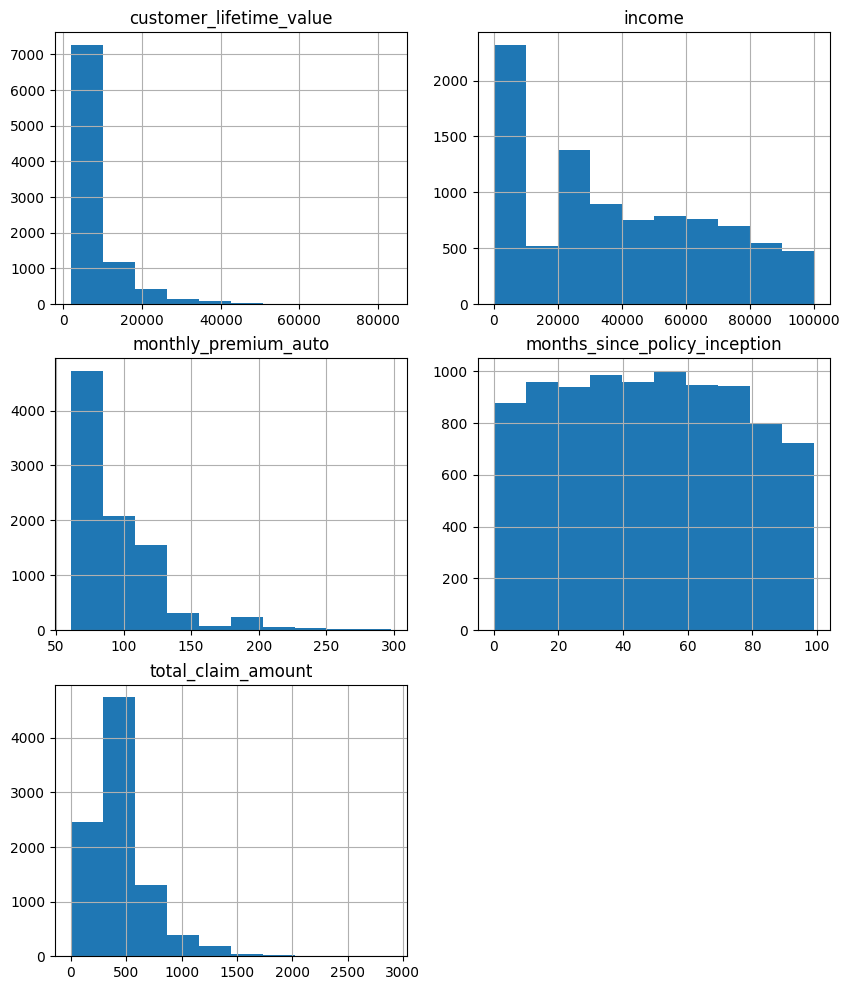

In [9]:
# Plotting histograms for continuous data
def plot_continuous(data):
    fig = plt.figure(figsize=(10,12)) 
    for n,column in enumerate(data):
        
        if is_continuous(data[column])==1:
            ax =plt.subplot(round_up(len(data.columns)/2),2,n+1)   
            data[column].hist()
            plt.title(column)
        
    plt.show()
    return

plot_continuous(continuous_df)

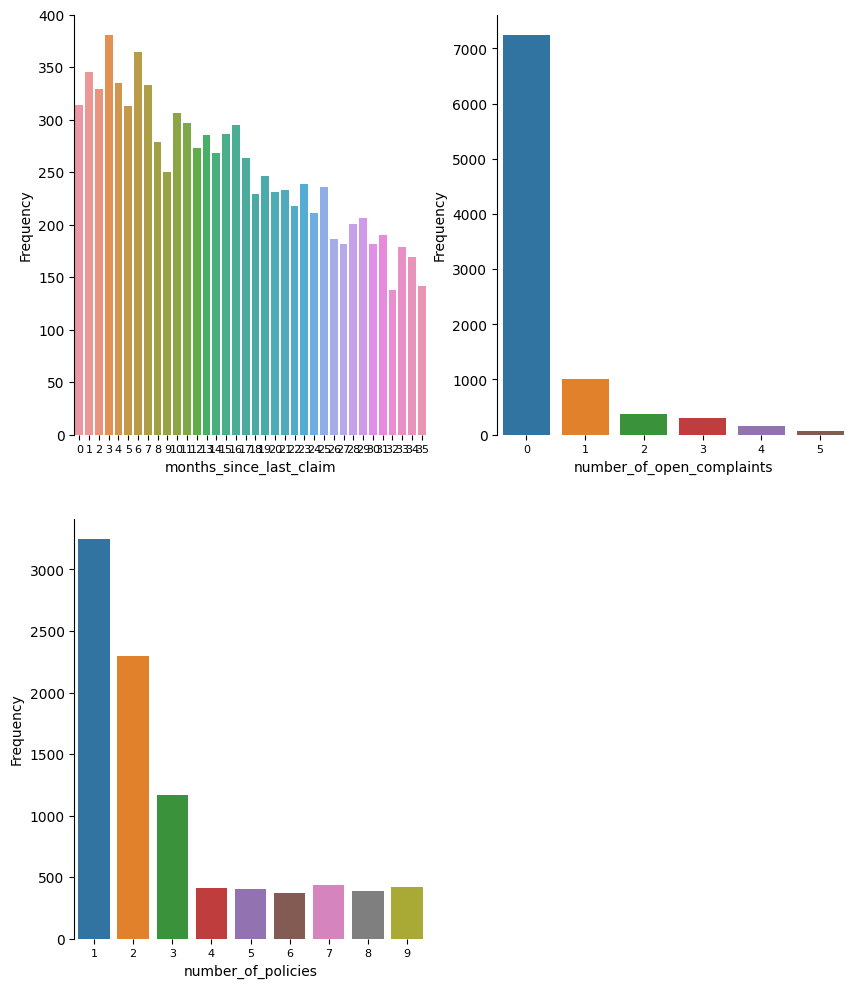

In [10]:
# Plotting histograms for continuous data
def plot_discrete(data):
    fig = plt.figure(figsize=(10,12)) 
    for n,column in enumerate(data):
        if is_continuous(data[column])==0:
            ax =plt.subplot(round_up(len(data.columns)/2),2,n+1)   

            sns.countplot(x = column, data=data)

            # Changing graph style
            sns.despine(bottom = True, left = False)
            plt.xticks(fontsize = 8)
            plt.ylabel('Frequency')
    plt.show()
    return

plot_discrete(discrete_df)

### 6. Look for outliers in the continuous variables. (HINT: There’s a good plot to do that!) Did you find outliers? Comment what you will do with them.

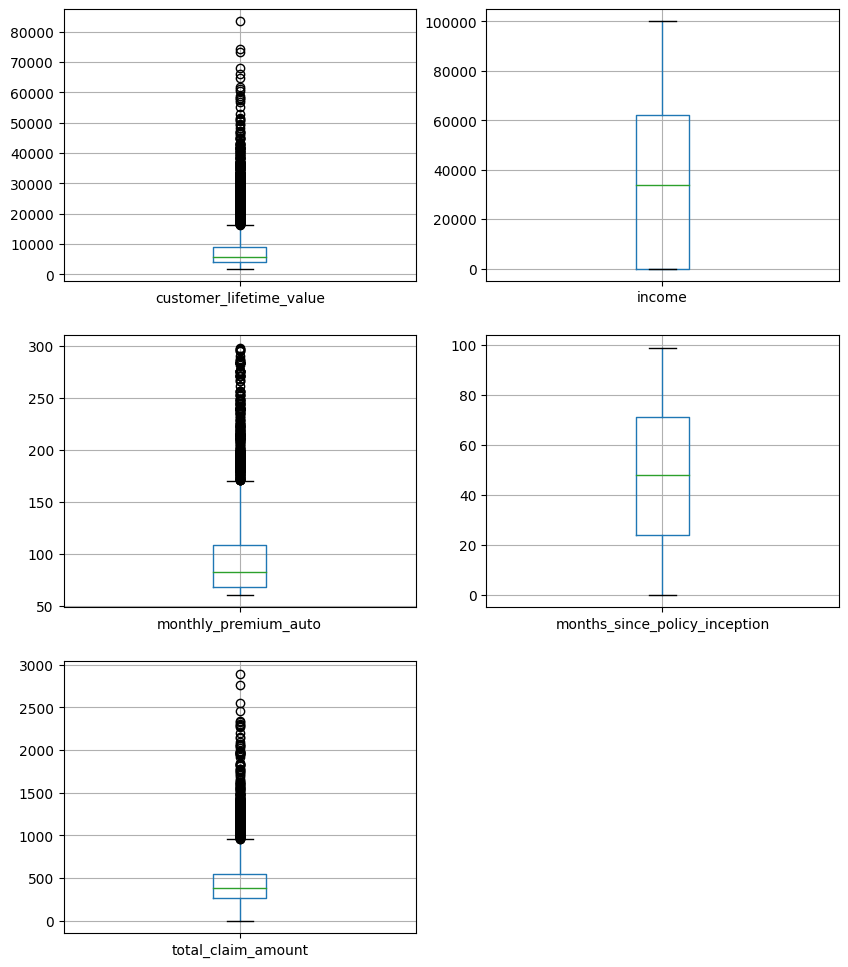

In [11]:
# Plotting boxplot
fig = plt.figure(figsize=(10,12)) 
for n,column in enumerate(continuous_df.columns):
    ax =plt.subplot(round_up(len(continuous_df.columns)/2),2,n+1)   
    continuous_df[[column]].boxplot()
plt.show()

# Instead of using the general formula 1.5*IQR I do a visual inspection
# and search for empty high ranges that are followed by some spread points,
# and target those as outliers.
    
# It seems customer_lifetime_value has some outliers over 51000:
continuous_df = continuous_df[continuous_df['customer_lifetime_value']<51000]
# , and total claim amount 4 over 2250.
continuous_df = continuous_df[continuous_df['total_claim_amount']<2200]
# , and monthly_premium_auto 4 over 260.
continuous_df = continuous_df[continuous_df['monthly_premium_auto']<260]

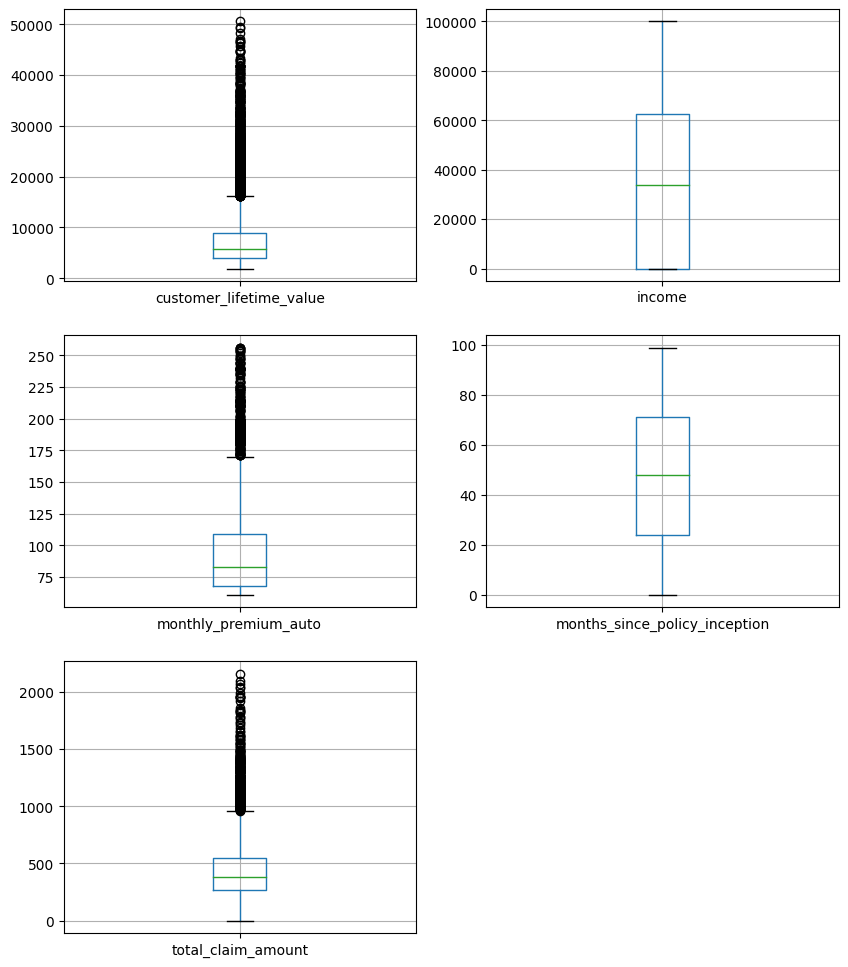

In [12]:
# and so the new plots without outliers are 
fig = plt.figure(figsize=(10,12)) 
for n,column in enumerate(continuous_df.columns):
    ax =plt.subplot(round_up(len(continuous_df.columns)/2),2,n+1)   
    continuous_df[[column]].boxplot()
plt.show()

#### Check all columns for NaN values. Decide what (if anything) you will need to do with them.

In [13]:
customer_df.isna().sum().sum()
# we don't have null values so there's nothing to do about it.

0

# Lab | Cleaning categorical data

#### Find all of the categorical data. Save it in a categorical_df variable.

In [14]:
categorical_df = customer_df.select_dtypes(object)

#### Check for NaN values.


In [15]:
categorical_df.isna().sum().sum()
# We have none 

0

#### Check all unique values of columns.

In [16]:
categorical_df.nunique()

customer             9134
state                   5
response                2
coverage                3
education               5
effective_to_date      59
employment_status       5
gender                  2
location_code           3
marital_status          3
policy_type             3
policy                  9
renew_offer_type        4
sales_channel           4
vehicle_class           6
vehicle_size            3
week_day                7
month                   2
dtype: int64

#### Check dtypes. Do they all make sense as categorical data?

In [17]:
categorical_df.dtypes
# Yes they do

customer             object
state                object
response             object
coverage             object
education            object
effective_to_date    object
employment_status    object
gender               object
location_code        object
marital_status       object
policy_type          object
policy               object
renew_offer_type     object
sales_channel        object
vehicle_class        object
vehicle_size         object
week_day             object
month                object
dtype: object

#### Does any column contain alpha and numeric data? Decide how to clean it.

In [18]:
#for column in categorical_df.drop(['effective_to_date'],axis=1).columns[1:]:
#    print('-----'+column+'-----')
#    print(categorical_df[column].value_counts())

# I checked for duplicates (for example California - CA) but every column seems to be in order.

# I'll remove customer ID becuase it's a unique identifier that gives us no information.
categorical_df = categorical_df.drop(['customer'],axis=1)

#### Would you choose to do anything else to clean or wrangle the categorical data? Comment your decisions.


In [19]:
# I guess I would leave it as it is. (later I will group some categories)

#### Compare policy_type and policy. What information is contained in these columns. Can you identify what is important?


In [20]:
categorical_df[['policy_type','policy']]
# It seems that policy_type information is contained within policy, so we could drop 'policy_type'
# and still have the same information.
categorical_df = categorical_df.drop(['policy_type'],axis=1)

#### Check number of unique values in each column, can they be combined in any way to ease encoding? Comment your thoughts and make those changes.

In [21]:
# If I was forced to do it I would for example combine "Master and PhD" in the education column and
# "Medical_leave,disabled and Retired" for employment status and so on
categorical_df['education'] = np.where(categorical_df['education'].isin(['Master','Doctor']),'Post bachelor', categorical_df['education'])
categorical_df['employment_status'] = np.where(categorical_df['employment_status'].isin(['Medical Leave','Disabled','Retired']),'Unable', categorical_df['employment_status'])
categorical_df['vehicle_class'] = np.where(categorical_df['vehicle_class'].isin(['Luxury SUV','Luxury Car']),'Luxury', categorical_df['vehicle_class'])

for column in categorical_df.drop(['effective_to_date'],axis=1).columns:
    print('-----'+column+'-----')
    print(categorical_df[column].value_counts())

-----state-----
California    3150
Oregon        2601
Arizona       1703
Nevada         882
Washington     798
Name: state, dtype: int64
-----response-----
No     7826
Yes    1308
Name: response, dtype: int64
-----coverage-----
Basic       5568
Extended    2742
Premium      824
Name: coverage, dtype: int64
-----education-----
Bachelor                2748
College                 2681
High School or Below    2622
Post bachelor           1083
Name: education, dtype: int64
-----employment_status-----
Employed      5698
Unemployed    2317
Unable        1119
Name: employment_status, dtype: int64
-----gender-----
F    4658
M    4476
Name: gender, dtype: int64
-----location_code-----
Suburban    5779
Rural       1773
Urban       1582
Name: location_code, dtype: int64
-----marital_status-----
Married     5298
Single      2467
Divorced    1369
Name: marital_status, dtype: int64
-----policy-----
Personal L3     3426
Personal L2     2122
Personal L1     1240
Corporate L3    1014
Corporate L2     5

# Lab | Feature extraction


#### 1. Open the categoricals variable we created before.



In [22]:
categorical_df.head()

,state,response,coverage,education,effective_to_date,employment_status,gender,location_code,marital_status,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size,week_day,month
0,Washington,No,Basic,Bachelor,2011-02-24,Employed,F,Suburban,Married,Corporate L3,Offer1,Agent,Two-Door Car,Medsize,Thursday,February
1,Arizona,No,Extended,Bachelor,2011-01-31,Unemployed,F,Suburban,Single,Personal L3,Offer3,Agent,Four-Door Car,Medsize,Monday,January
2,Nevada,No,Premium,Bachelor,2011-02-19,Employed,F,Suburban,Married,Personal L3,Offer1,Agent,Two-Door Car,Medsize,Saturday,February
3,California,No,Basic,Bachelor,2011-01-20,Unemployed,M,Suburban,Married,Corporate L2,Offer1,Call Center,SUV,Medsize,Thursday,January
4,Washington,No,Basic,Bachelor,2011-02-03,Employed,M,Rural,Single,Personal L1,Offer1,Agent,Four-Door Car,Medsize,Thursday,February


#### 2. Plot all the categorical variables with the proper plot. What can you see?

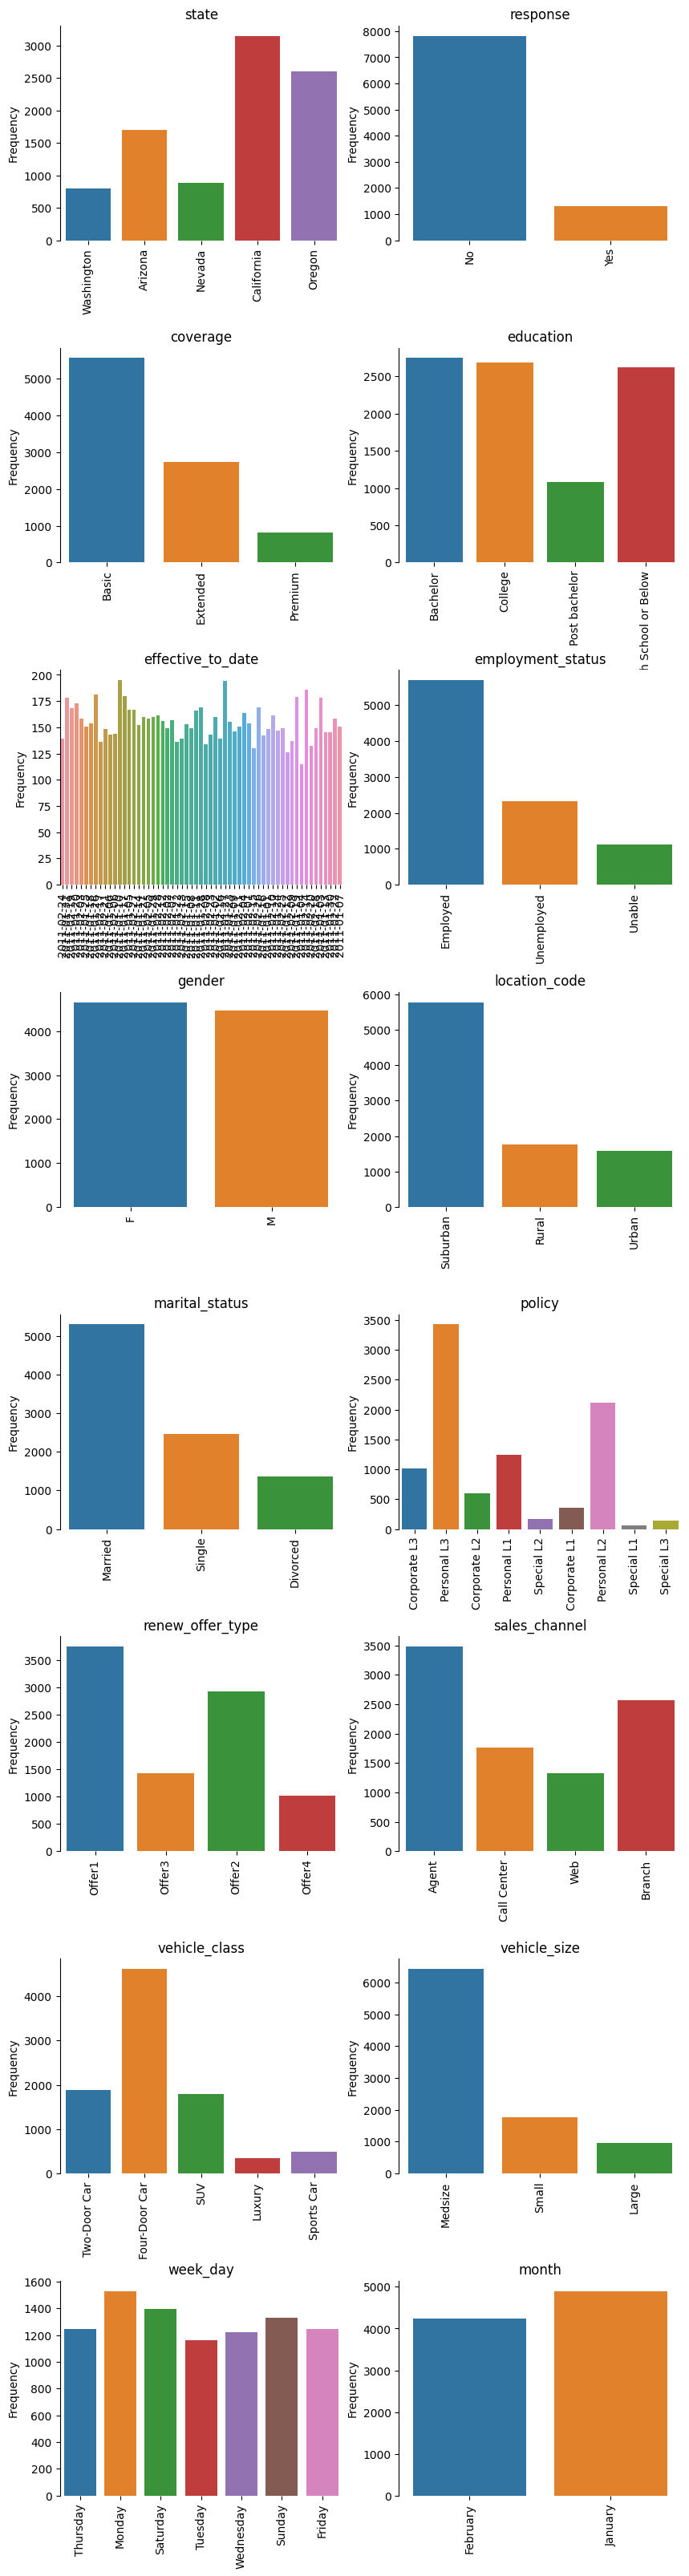

In [23]:
fig = plt.figure(figsize=(10,40)) 
for n,column in enumerate(categorical_df.columns):
    ax =plt.subplot(round_up(len(categorical_df.columns)/2),2,n+1)  

    # -- Show a plot of the total number of responses.
    sns.countplot(x = column, data=categorical_df)

    # Changing graph style
    sns.despine(bottom = True, left = False)
    plt.xticks(rotation = 90)
    plt.ylabel('Frequency')
    plt.xlabel('')
    plt.title(column)
plt.subplots_adjust(hspace=0.5)
plt.show()

#### 3.There might be some columns that seem to be redundant, check their values to be sure. What should we do with them?


In [24]:
# We already did that

#### 4.Plot time variable. Can you extract something from it?


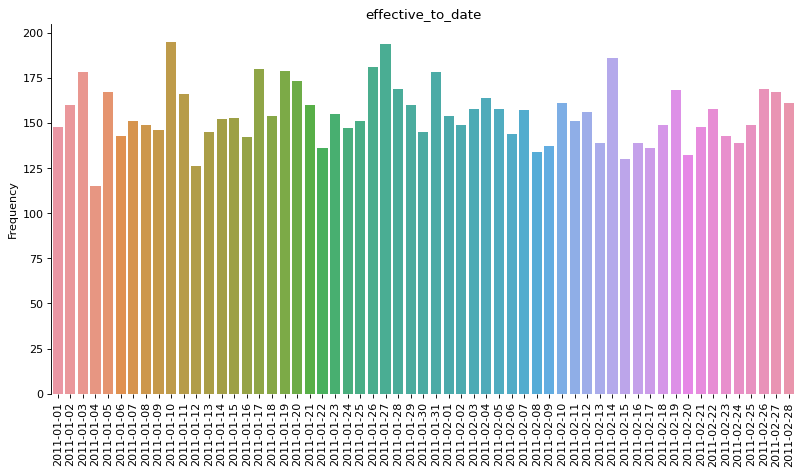

In [25]:
plt.figure(figsize=(12, 6), dpi=80)
sns.countplot(x = 'effective_to_date', data=categorical_df.sort_values(by='effective_to_date'))
# The data seems to be equally distributed along the dates. It has a bit of noise, we could
# check if it's a periodic behaviour (maybe on weeks) and maybe we could see that by creating
# a new column with the workday and checking if there's a difference there.

# Changing graph style
sns.despine(bottom = True, left = False)
plt.xticks(fontsize=10, rotation=90)
plt.ylabel('Frequency')
plt.xlabel('')
plt.title('effective_to_date')
plt.show()


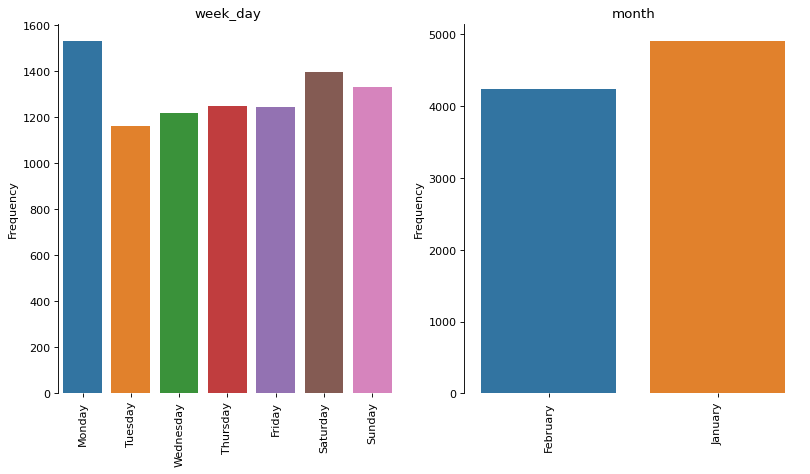

In [26]:
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.figure(figsize=(12, 6), dpi=80)

# Plot days
ax = plt.subplot(1,2,1)  
sns.countplot(x = 'week_day', data=categorical_df, order = order)

# Changing graph style
sns.despine(bottom = True, left = False)
plt.xticks(fontsize=10, rotation=90)
plt.ylabel('Frequency')
plt.xlabel('')
plt.title('week_day')

# Although there's a big difference between mondays and tuesdays, the rest of the week it seems to be
# relatively more steady, so I think my assumption was wrong. 
# So we can't assume the periodic behaviour it's based on the weeks, but we can see that
# mondays has a much higher frequency than the rest of the week (and that the frequency
# seems to increase throughout the week). 

# Plot months
ax = plt.subplot(1,2,2)  
sns.countplot(x = 'month', data=categorical_df)
# Changing graph style
sns.despine(bottom = True, left = False)
plt.xticks(fontsize=10, rotation=90)
plt.ylabel('Frequency')
plt.xlabel('')
plt.title('month')

plt.show()

# We can also see January has a higher frequency.

# Lab | Comparing regression models

In [27]:
# I merge everything back by an inner join on index (so I lose the rows which I removed
# from continuous when deleting outliers, otherwise they will be filled with NANs)
data = pd.concat([continuous_df,discrete_df,categorical_df],axis=1)
data = continuous_df.merge(discrete_df, how='inner', left_index=True, right_index=True)
data = data.merge(categorical_df, how='inner', left_index=True, right_index=True)
data = data.reset_index(drop=True)

#### In this final lab, we will model our data. Import sklearn train_test_split and separate the data.

In [28]:
X = data.drop(['total_claim_amount'],axis=1)
y = data['total_claim_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### We will start with removing outliers, if you have not already done so. 
I already did that. I didn't use the general rule of 1.5xinterquartile_range. Instead, I did a visual inspection and looked for ranges outside 1.5*interquartile_range, and when there was a long range without values and then a few of them, I identified them as outliers and removed them

#### Create a copy of the dataframe for the data wrangling.

In [29]:
# I'm not sure what data wrangling is.
backup_copy = data.copy()

#### Encode the categorical variables (See the hint below for encoding categorical data!!!)
| Encoder Type| Column |
| ----------- | ----------- |
|One hot |state|
|Ordinal| coverage|
|Ordinal| employmentstatus|
|Ordinal| location code|
|One hot| marital status|
|One hot| policy type|
|One hot| renew offer|
|One hot| sales channel|
|One hot| vehicle class|
|Ordinal| vehicle size|


##### One hot columns

In [30]:
oh_columns = ['state','marital_status','policy','renew_offer_type','sales_channel','vehicle_class','week_day','month']
total = 0

# Counting and printing how many unique value each OH column has
for column in oh_columns:
    print('The column ' +column+ ' has ' + str(len(X_train[column].value_counts()))+' unique values.')
    total += len(X_train[column].value_counts())
print('\nIn total we have %i unique values, which is handleable.' %total)

# Transforming train data
onehot_train = X_train[oh_columns]
encoder = OneHotEncoder(handle_unknown='error',drop='first').fit(onehot_train) 
encoded = pd.DataFrame(encoder.transform(onehot_train).toarray(),columns=encoder.get_feature_names_out(onehot_train.columns))

# Transforming test data
onehot_test = X_test[oh_columns]
encoded_test = pd.DataFrame(encoder.transform(onehot_test).toarray(),columns=encoder.get_feature_names_out(onehot_test.columns))

The column state has 5 unique values.
The column marital_status has 3 unique values.
The column policy has 9 unique values.
The column renew_offer_type has 4 unique values.
The column sales_channel has 4 unique values.
The column vehicle_class has 5 unique values.
The column week_day has 7 unique values.
The column month has 2 unique values.

In total we have 39 unique values, which is handleable.


##### Ordinal columns

In [31]:
# function that labels the columns according to the order_list provided
def labeling(df,ord_columns,order_list):
    new_df = df.copy()
    
    #iterating for each column I want to label
    for column in ord_columns:
        # iterating for each unique category from that column
        for category in order_list[ord_columns.index(column)]:
            # I search for values where column = category and replace by the index of the order_list
            new_df[column]=new_df[column].mask(new_df[column]==category,order_list[ord_columns.index(column)].index(category)+1)
    
        # When I'm done with a column, I convert to numeric. If it can't it's because 
        # there's a new category on test data and in that case 
        # the function won't work and so I will now there's a new cat.
        new_df[column]=pd.to_numeric(new_df[column])
        
    # I reset the index because onehot does the same and I need to concat later
    new_df=new_df.reset_index(drop=True)
    
    return new_df

In [32]:
ord_columns = ['coverage','employment_status','location_code','vehicle_size']
order_lists = [['Basic','Extended','Premium'],
               ['Unable','Unemployed','Employed'],
               ['Rural','Suburban','Urban'],
               ['Small','Medsize','Large']]

# labeling training and testing data.
ord_train_labeled = labeling(X_train[ord_columns],ord_columns,order_lists)
ord_test_labeled = labeling(X_test[ord_columns],ord_columns,order_lists)

In [33]:
# Concatenating the data back.
X_train_cat = pd.concat([encoded,ord_train_labeled],axis=1)
X_test_cat = pd.concat([encoded_test,ord_test_labeled],axis=1)

#### Normalize the continuous variables. You can use any one method you want.

In [34]:
# I also reset the index of X because of the same reason
X_train=X_train.reset_index(drop=True)
X_test=X_test.reset_index(drop=True)

# I "drop" the old categorical and then in the next code concat the labeled ones
X_train_numerical = X_train.select_dtypes(np.number) 
X_test_numerical = X_test.select_dtypes(np.number)

# I concatenate everything because I have to minmax everything
X_train_almost_ready = pd.concat([X_train_numerical,X_train_cat],axis=1)
X_test_almost_ready = pd.concat([X_test_numerical,X_test_cat],axis=1)

# Minmaxing train data
transformer = MinMaxScaler().fit(X_train_almost_ready)
X_train_ready = transformer.transform(X_train_almost_ready)
X_train_ready = pd.DataFrame(X_train_ready, columns=X_train_almost_ready.columns)

# Minmaxing test data
X_test_ready = transformer.transform(X_test_almost_ready)
X_test_ready = pd.DataFrame(X_test_ready, columns=X_test_almost_ready.columns)

#### The time variable can be useful. Try to transform its data into a useful one. Hint: Day week and month as integers might be useful. 
Already done

#### Since the model will only accept numerical data, check and make sure that every column is numerical, if some are not, change it using encoding.
Already done

#### Try a simple linear regression with all the data to see whether we are getting good results.

In [36]:
lm = linear_model.LinearRegression()
lm.fit(X_train_ready,y_train)
lm.score(X_test_ready,y_test)
# The result is somewhat decent, R2 ~ 0.58

0.5782664852970851

#### Great! Now define a function that takes a list of models and train (and tests) them so we can try a lot of them without repeating code.

In [38]:
# First checking a normal KNN model
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train_ready, y_train)
print(model.score(X_train_ready,y_train))
print(model.score(X_test_ready, y_test))
# We see that it doesn't really work for the test

0.5918646513910691
0.3589246049570106


In [39]:
def optimizing_model(data_train,data_test,list_k,list_p):
    # Function that iterates for each combination of k,p to get the score of the 
    # knn model with said paramaters. 
    X_train,y_train = data_train[0],data_train[1]
    X_test,y_test = data_test[0],data_test[1]

    scores = []
    combinations = []
    for k in list_k:
        for p in list_p:
            model =  KNeighborsRegressor(n_neighbors=k, weights='distance',p=p)
            model.fit(X_train, y_train)
            scores.append(model.score(X_test, y_test))
            combinations.append((k,p))
    return scores,combinations

In [40]:
list_k = range(2,10)
list_p = range(1,5)
scores,combinations = optimizing_model([X_train_ready,y_train],[X_test_ready,y_test],
                                       list_k=list_k,list_p=list_p)

In [42]:
print('The best score we got is %.2f which comes from the combination k=%i,p=%i' %(max(scores),combinations[scores.index(max(scores))][0],combinations[scores.index(max(scores))][1]))
print('\nHowever the linear regression seems to work best even if its more simple.')

The best score we got is 0.53 which comes from the combination k=8,p=1

However the linear regression seems to work best even if its more simple


# Lab | Random variable distributions

#### Get the numerical variables from our dataset.

In [43]:
num = data.select_dtypes(np.number)

#### Check using a distribution plot if the variables fit the theoretical normal or exponential distribution.

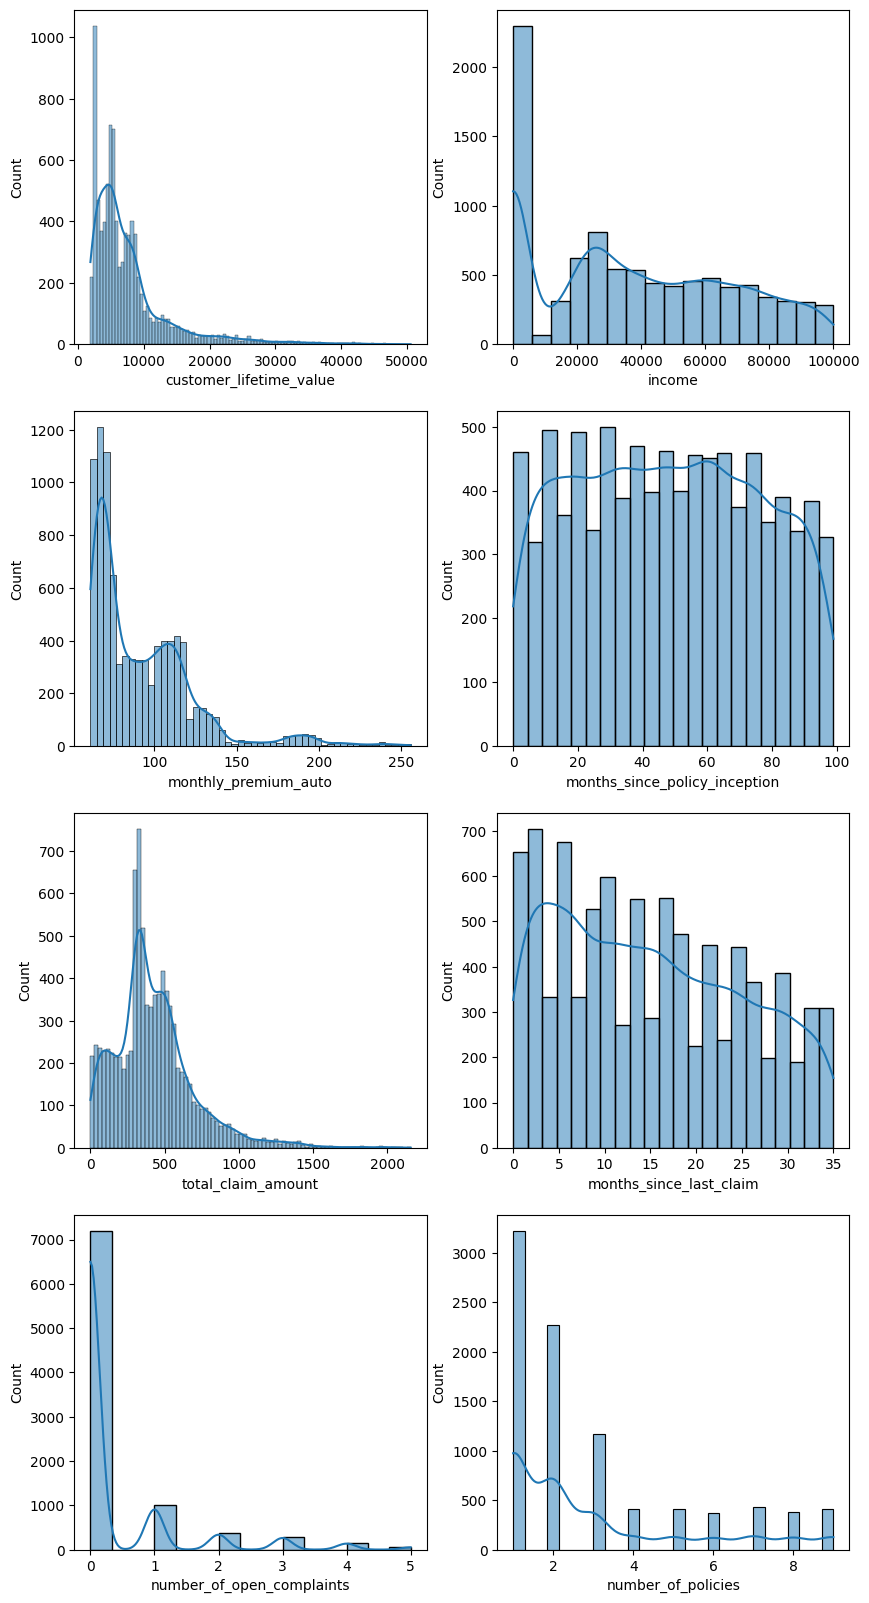

In [60]:
fig = plt.figure(figsize=(10,20)) 
for n,column in enumerate(num.columns):
    ax = plt.subplot(round_up(len(num.columns)/2),2,n+1)  
    sns.histplot(num[column],kde=True)
    
plt.show()
    
#customer_lifetime_value looks exponencial
#income looks weird (I don't understand why do we have so many people with 0 income)
#monthly_premium_auto looks exponencial
#months_since_policy_inception looks normal
#total_claim_amount looks like normal one
#months_since_last_claim looks normal?
#number_of_open_complaints looks exponencial
#number_of_policies looks exponencial

#### Check if any of the transformations (log-transform, etc.) we have seen up to this point changes the result.

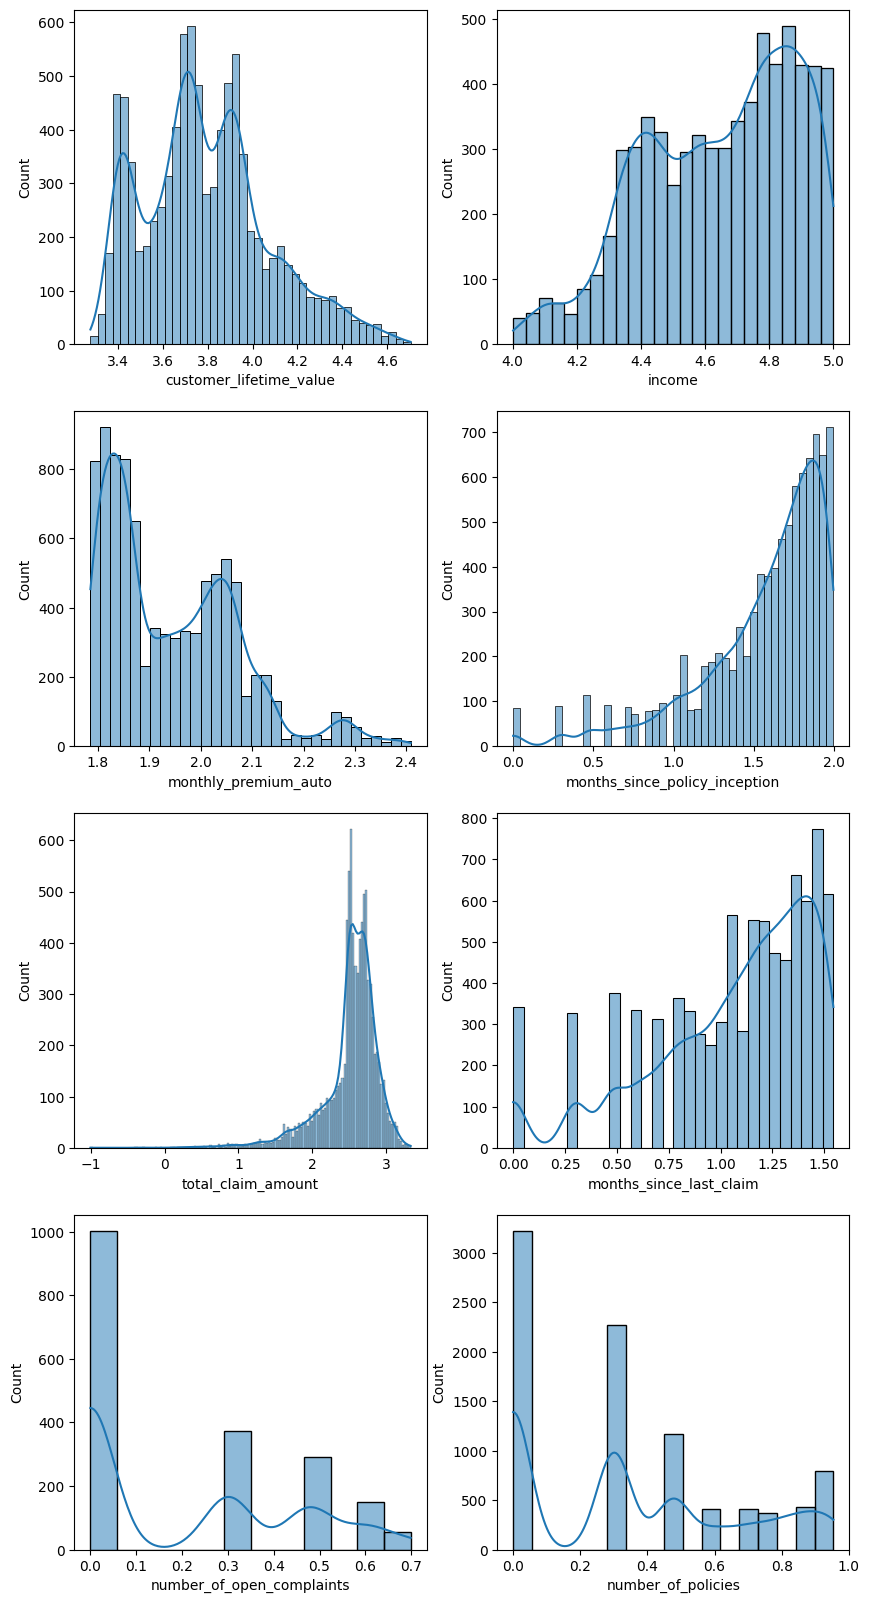

In [61]:
def log_transform(x):
    if x>0:
        return np.log10(x)
    else:
        return np.nan
    
num2 = num.copy()
num2 = num2.applymap(log_transform)

fig = plt.figure(figsize=(10,20)) 
for n,column in enumerate(num2.columns):
    ax = plt.subplot(round_up(len(num2.columns)/2),2,n+1)  
    sns.histplot(num2[column],kde=True)
plt.show()

In [62]:
# now customer_lifetime_value looks normal and total claim amount looks incredibly normal